# IBKT Evaluation (Exported Sessions)

This notebook evaluates the IBKT model on exported game sessions. It prefers preprocessed exports when available and falls back to the raw flat export; synthetic data is only used in separate sandbox notebooks.

Notes
- Data sources: `exports/gamesessions_224_235_flat_preprocessed.csv` → `exports/gamesessions_224_235_flat.csv`
- Key artifacts: overall metrics (log-likelihood, AUC), breakdowns by game type, difficulty, subtopic, and a few diagnostic plots.
- This notebook is for internal validation; not included in the paper.


In [31]:
# Preprocessing: load exported flattened game-session CSV and convert difficulty to numeric levels
# This cell creates a `difficulty_level` column (1..4) for IBKT preprocessing and saves a preprocessed CSV.
import pandas as pd
from pathlib import Path

EXPORT_CSV = Path('../exports') / 'gamesessions_224_235_flat.csv'
if not EXPORT_CSV.exists():
    raise FileNotFoundError(f"Expected export CSV at {EXPORT_CSV} — run the export and flatten scripts first")

# Read CSV and parse datetimes
df = pd.read_csv(EXPORT_CSV, parse_dates=['start_time', 'end_time', 'answered_at'], low_memory=False)

# Map textual difficulty to numeric levels for IBKT (you can change mapping here)
DIFFICULTY_MAP = {
    'beginner': 1,
    'intermediate': 2,
    'advanced': 3,
    'master': 4,
}

# Some rows may have missing estimated_difficulty; set to 0 to indicate unknown
df['difficulty_level'] = df['estimated_difficulty'].map(DIFFICULTY_MAP).fillna(0).astype(int)

# Optional: if your IBKT expects item IDs and student IDs as integers / specific column names,
# create or rename them here. Example mappings below (adjust as needed by your IBKT code):
# - 'user_id' -> learner_id
# - 'generated_question_id' -> item_id
# - 'is_correct' -> correct (0/1)

df = df.rename(columns={
    'user_id': 'learner_id',
    'generated_question_id': 'item_id',
    'is_correct': 'correct'
})

# Ensure 'correct' is integer 0/1
if df['correct'].dtype == bool:
    df['correct'] = df['correct'].astype(int)
else:
    df['correct'] = pd.to_numeric(df['correct'], errors='coerce').fillna(0).astype(int)

# Save a preprocessed CSV that your notebook's IBKT routine can load
PREPROCESSED = EXPORT_CSV.with_name(EXPORT_CSV.stem + '_preprocessed.csv')
df.to_csv(PREPROCESSED, index=False)

print(f'Preprocessed {len(df)} rows; saved to {PREPROCESSED}')

Preprocessed 109 rows; saved to ..\exports\gamesessions_224_235_flat_preprocessed.csv


# iBKT Model Fit & Predictive Validity Evaluation

This notebook demonstrates how to evaluate an Individualized Bayesian Knowledge Tracing (iBKT) model using Model Fit (Log-Likelihood) and Predictive Validity (AUC-ROC) on mock session data for coding and non-coding tasks.

In [32]:
import math, random
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# Import your BKT from the project (preferred)
try:
    from user_learning.adaptive_engine import BKTParams, bkt_update_once
except Exception:
    # Fallback minimal BKT to keep the notebook runnable
    from dataclasses import dataclass
    @dataclass
    class BKTParams:
        p_L0: float = 0.20
        p_T: float = 0.10
        p_T_wrong: float = 0.00
        p_S: float = 0.10
        p_G: float = 0.20
        decay_wrong: float = 0.85
        min_floor: float = 1e-6
        max_ceiling: float = 1-1e-6
    def bkt_update_once(p_know: float, correct: bool, p: BKTParams) -> float:
        if correct:
            num = p_know * (1 - p.p_S)
            den = num + (1 - p_know) * p.p_G
            pT = p.p_T
        else:
            num = p_know * p.p_S
            den = num + (1 - p_know) * (1 - p.p_G)
            pT = p.p_T_wrong
        post = 0.0 if den == 0 else num / den
        p_next = post + (1 - post) * pT
        if not correct:
            p_next *= p.decay_wrong
        return max(p.min_floor, min(p.max_ceiling, p_next))

random.seed(7)
np.random.seed(7)


In [33]:
# Quick check: show DataFrame columns available after loading real data
print('Columns in df:', list(df.columns))
print('\nSample dtypes:')
print(df.dtypes.head(12))


Columns in df: ['session_pk', 'session_id', 'learner_id', 'username', 'session_game_type', 'session_status', 'start_time', 'end_time', 'total_score', 'time_limit', 'gamequestion_id', 'item_id', 'question_text', 'correct_answer', 'estimated_difficulty', 'question_game_type', 'response_id', 'response_user_id', 'response_username', 'user_answer', 'correct', 'time_taken', 'answered_at', 'difficulty_level']

Sample dtypes:
session_pk                         int64
session_id                        object
learner_id                         int64
username                          object
session_game_type                 object
session_status                    object
start_time           datetime64[ns, UTC]
end_time             datetime64[ns, UTC]
total_score                        int64
time_limit                         int64
gamequestion_id                    int64
item_id                            int64
dtype: object


## Mock data generator (coding + non-coding)


We will create mock response data for both coding and non-coding sessions. Each entry represents a learner's response sequence for a subtopic.

In [34]:
def make_mock_df_with_sessions(num_users=3, noncoding_sessions=6, coding_sessions=6,
                               subtopic_pool=range(101, 121), p_correct_mu=0.7, p_correct_sigma=0.15):
    rows = []
    base = datetime.now()
    diffs = ["beginner","intermediate","advanced","master"]
    sid = 1

    for u in range(1, num_users+1):
        # Non-coding sessions (≤10 Q each, subtopics can vary per question)
        for _ in range(noncoding_sessions):
            n_q = np.random.randint(6, 11)  # 6..10
            p_acc = float(np.clip(np.random.normal(p_correct_mu, p_correct_sigma), 0.3, 0.95))
            for q_idx in range(1, n_q+1):
                sub = int(np.random.choice(subtopic_pool))
                diff = np.random.choice(diffs, p=[0.35,0.40,0.20,0.05])
                is_correct = int(np.random.rand() < p_acc)
                tstamp = base + timedelta(minutes=sid, seconds=q_idx*15)
                rows.append({
                    "user_id": u,
                    "session_id": f"NC-{u}-{sid}",
                    "q_idx": q_idx,
                    "subtopic_id": sub,
                    "game_type": "non_coding",
                    "is_correct": is_correct,
                    "estimated_difficulty": diff,
                    "timestamp": tstamp
                })
            sid += 1

        # Coding sessions (exactly 1 Q each)
        for _ in range(coding_sessions):
            p_acc = float(np.clip(np.random.normal(p_correct_mu, p_correct_sigma), 0.3, 0.95))
            sub = int(np.random.choice(subtopic_pool))
            diff = np.random.choice(diffs, p=[0.35,0.40,0.20,0.05])
            is_correct = int(np.random.rand() < p_acc)
            tstamp = base + timedelta(minutes=sid)
            rows.append({
                "user_id": u,
                "session_id": f"C-{u}-{sid}",
                "q_idx": 1,
                "subtopic_id": sub,
                "game_type": "coding",
                "is_correct": is_correct,
                "estimated_difficulty": diff,
                "timestamp": tstamp,
            })
            sid += 1

    df_mock = pd.DataFrame(rows).sort_values(["user_id","timestamp","session_id","q_idx"]).reset_index(drop=True)
    return df_mock

# Attempt to load the preprocessed real data (created by earlier preprocessing cell)
from pathlib import Path
PREPROCESSED = Path('../exports') / 'gamesessions_224_235_flat_preprocessed.csv'
RAW_FLAT = Path('../exports') / 'gamesessions_224_235_flat.csv'

if PREPROCESSED.exists():
    print(f"Loading preprocessed data from {PREPROCESSED}")
    df = pd.read_csv(PREPROCESSED, low_memory=False)
    # parse datetimes for available columns
    for c in ['start_time','end_time','answered_at','timestamp']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
    # Harmonize column names expected by the notebook helpers
    # Ensure user_id exists (some exports may use 'learner_id')
    if 'learner_id' in df.columns and 'user_id' not in df.columns:
        df = df.rename(columns={'learner_id': 'user_id'})
    # prefer 'item_id' or 'generated_question_id' as surrogate for subtopic/item
    if 'generated_question_id' in df.columns and 'subtopic_id' not in df.columns:
        df['subtopic_id'] = df['generated_question_id']
    if 'item_id' in df.columns and 'subtopic_id' not in df.columns:
        df['subtopic_id'] = df['item_id']
    if 'answered_at' in df.columns and 'timestamp' not in df.columns:
        df['timestamp'] = pd.to_datetime(df['answered_at'], errors='coerce')
    if 'session_game_type' in df.columns and 'game_type' not in df.columns:
        df['game_type'] = df['session_game_type']
    # Ensure boolean/numeric is_correct
    if 'correct' in df.columns and 'is_correct' not in df.columns:
        df['is_correct'] = pd.to_numeric(df['correct'], errors='coerce').fillna(0).astype(int)
    else:
        if 'is_correct' in df.columns:
            df['is_correct'] = pd.to_numeric(df['is_correct'].replace({True:1, False:0}), errors='coerce').fillna(0).astype(int)
        else:
            # fallback: try column named 'user_answer' vs 'correct_answer' — set is_correct=0 if unknown
            df['is_correct'] = 0

    # If q_idx missing, will be added later by add_sessions_if_missing
    print(f"Loaded {len(df)} rows from preprocessed file")

elif RAW_FLAT.exists():
    print(f"Preprocessed file not found, loading raw flattened CSV {RAW_FLAT} and deriving needed columns")
    df = pd.read_csv(RAW_FLAT, low_memory=False)
    for c in ['start_time','end_time','answered_at']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
    if 'generated_question_id' in df.columns and 'subtopic_id' not in df.columns:
        df['subtopic_id'] = df['generated_question_id']
    if 'item_id' in df.columns and 'subtopic_id' not in df.columns:
        df['subtopic_id'] = df['item_id']
    if 'answered_at' in df.columns:
        df['timestamp'] = pd.to_datetime(df['answered_at'], errors='coerce')
    if 'session_game_type' in df.columns and 'game_type' not in df.columns:
        df['game_type'] = df['session_game_type']
    if 'is_correct' in df.columns:
        df['is_correct'] = pd.to_numeric(df['is_correct'].replace({True:1, False:0}), errors='coerce').fillna(0).astype(int)
    elif 'correct' in df.columns:
        df['is_correct'] = pd.to_numeric(df['correct'], errors='coerce').fillna(0).astype(int)
    else:
        df['is_correct'] = 0
    print(f"Loaded {len(df)} rows from raw flattened file")

else:
    print("No exported data found; falling back to mock data generator")
    df = make_mock_df_with_sessions()

# Show top rows for quick verification
print(df.head().to_string())


Loading preprocessed data from ..\exports\gamesessions_224_235_flat_preprocessed.csv
Loaded 109 rows from preprocessed file
   session_pk                            session_id  user_id username session_game_type session_status                       start_time                         end_time  total_score  time_limit  gamequestion_id  item_id                                                                 question_text correct_answer estimated_difficulty question_game_type  response_id  response_user_id response_username user_answer  correct  time_taken                      answered_at  difficulty_level  subtopic_id                        timestamp  game_type  is_correct
0         224  b1118763-b661-419d-974f-00425a829d3f        8  JohnDoe         crossword      completed 2025-10-26 05:13:10.965360+00:00 2025-10-26 05:13:49.054570+00:00            0         300             1105       25  Identify the concept for combining numbers with symbols like plus and minus.    expressions         

## Evaluate Log-Likelihood and AUC-ROC (overall)


In [35]:
# ================================================================
# iBKT evaluation helpers (Log-Likelihood + AUC), grouped variants
# ================================================================
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from IPython.display import display

def eval_ibkt_ll_auc(df: pd.DataFrame, params: BKTParams = None):
    """
    Computes log-likelihood and AUC-ROC for iBKT.
    Assumes df has columns: user_id, subtopic_id, is_correct (0/1)
    Optional: estimated_difficulty, timestamp (for sorting)
    Uses bkt_update_once from Cell 1.
    """
    params = params or BKTParams()

    # Sort to ensure temporal order per learner
    sort_cols = ["user_id"]
    if "timestamp" in df.columns:
        sort_cols.append("timestamp")
    if "session_id" in df.columns and "q_idx" in df.columns:
        sort_cols.extend(["session_id", "q_idx"])

    data = df.sort_values(sort_cols).reset_index(drop=True)

    preds, labels = [], []
    # per (user, subtopic) state
    pL = defaultdict(lambda: params.p_L0)

    for (u, s), g in data.groupby(["user_id", "subtopic_id"], sort=False):
        p = pL[(u, s)]
        for _, row in g.iterrows():
            # predicted prob BEFORE observing
            p_correct = p * (1 - params.p_S) + (1 - p) * params.p_G
            p_correct = float(np.clip(p_correct, 1e-9, 1 - 1e-9))
            preds.append(p_correct)
            labels.append(int(row.is_correct))

            # update mastery using observed outcome
            p = bkt_update_once(p, bool(row.is_correct), params)
        pL[(u, s)] = p

    preds = np.array(preds, dtype=float)
    labels = np.array(labels, dtype=int)

    # Log-likelihood
    LL = float(np.sum(labels * np.log(preds) + (1 - labels) * np.log(1 - preds)))
    avg_LL = LL / len(labels) if len(labels) else float("nan")

    # AUC-ROC
    auc = roc_auc_score(labels, preds) if len(np.unique(labels)) > 1 else float("nan")

    return {
        "n_obs": int(len(labels)),
        "log_likelihood": LL,
        "avg_log_likelihood": avg_LL,
        "auc_roc": auc,
    }

def eval_by_group(df: pd.DataFrame, group_col: str):
    rows = []
    for key, g in df.groupby(group_col):
        m = eval_ibkt_ll_auc(g.copy())
        rows.append({group_col: key, **m})
    return pd.DataFrame(rows).sort_values(group_col)


## Output Metrics in Summary Table

Display the Log-Likelihood and AUC-ROC for each session type in a concise table.

In [36]:
from IPython.display import display


# ================================================================
# 🔧 Auto-assign sessions if missing + sanity checks + breakdowns
# ================================================================

from datetime import datetime

def add_sessions_if_missing(df):
    """
    Ensure df has 'session_id' and 'q_idx'.
    Rules:
      • coding → exactly 1 question per session (q_idx=1)
      • non_coding → batch into sessions of ≤10 questions (q_idx=1..10)
    Sorting uses timestamp if present; otherwise preserves current order.
    """
    need_base = {"user_id", "game_type"}
    missing = need_base - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # If already present, return as-is
    if {"session_id", "q_idx"}.issubset(df.columns):
        return df

    sort_cols = ["user_id"]
    if "timestamp" in df.columns:
        sort_cols.append("timestamp")
    if "q_idx" in df.columns:  # just in case a different q_idx exists
        sort_cols.append("q_idx")

    df = df.sort_values(sort_cols).reset_index(drop=True).copy()

    session_ids, q_indices = [], []

    # Per-user counters
    nc_counts  = {}  # count within current non_coding session
    nc_sessno  = {}  # non_coding session number per user
    c_sessno   = {}  # coding session number per user

    for _, row in df.iterrows():
        u  = row["user_id"]
        gt = str(row["game_type"]).strip().lower()

        if gt == "coding":
            c_sessno[u] = c_sessno.get(u, 0) + 1
            session_ids.append(f"C-{u}-{c_sessno[u]}")
            q_indices.append(1)
        else:
            nc_counts[u] = nc_counts.get(u, 0)
            nc_sessno[u] = nc_sessno.get(u, 0)

            if nc_counts[u] == 0:
                nc_sessno[u] += 1  # start a new non_coding session

            nc_counts[u] += 1
            session_ids.append(f"NC-{u}-{nc_sessno[u]}")
            q_indices.append(nc_counts[u])

            if nc_counts[u] >= 10:
                nc_counts[u] = 0  # next question starts a new session

    df["session_id"] = session_ids
    df["q_idx"] = q_indices
    return df


# 1) Ensure session_id and q_idx exist
df = add_sessions_if_missing(df)

# 2) Sanity checks
assert (
    df[df.game_type.str.lower() == "non_coding"]
      .groupby("session_id")["q_idx"].max()
      .le(10).all()
), "❌ Non-coding session exceeds 10 questions!"

assert (
    df[df.game_type.str.lower() == "coding"]
      .groupby("session_id")["q_idx"].max()
      .eq(1).all()
), "❌ A coding session has more than one question!"

print("✅ Session structure checks passed.")


# 3) Extra breakdowns
overall = eval_ibkt_ll_auc(df)
print(f"\n=== Overall Model Performance ===")
print(f"Log-Likelihood (avg): {overall['avg_log_likelihood']:.4f}")
print(f"AUC-ROC: {overall['auc_roc']:.3f}")

print("\n=== Breakdown by Game Type ===")
by_game = eval_by_group(df, "game_type")
display(by_game)

print("\n=== Breakdown by Difficulty ===")
by_diff = eval_by_group(df, "estimated_difficulty")
display(by_diff)

print("\n=== Breakdown by Subtopic (first 10) ===")
by_subtopic = eval_by_group(df, "subtopic_id")
display(by_subtopic.head(10))


✅ Session structure checks passed.



=== Overall Model Performance ===
Log-Likelihood (avg): -0.6338
AUC-ROC: 0.584

=== Breakdown by Game Type ===


,game_type,n_obs,log_likelihood,avg_log_likelihood,auc_roc
0,crossword,109,-69.084543,-0.633803,0.583877



=== Breakdown by Difficulty ===


,estimated_difficulty,n_obs,log_likelihood,avg_log_likelihood,auc_roc
0,advanced,13,-8.312751,-0.639442,0.687500
1,beginner,28,-18.562715,-0.662954,0.508333
2,intermediate,45,-26.625705,-0.591682,0.623272
3,master,23,-15.583371,-0.677538,0.470833



=== Breakdown by Subtopic (first 10) ===


,subtopic_id,n_obs,log_likelihood,avg_log_likelihood,auc_roc
0,16,1,-1.078810,-1.078810,NaN
1,17,1,-0.415515,-0.415515,NaN
2,18,1,-0.415515,-0.415515,NaN
3,19,1,-1.078810,-1.078810,NaN
4,21,1,-1.078810,-1.078810,NaN
5,25,2,-0.661455,-0.330727,NaN
6,26,1,-1.078810,-1.078810,NaN
7,28,1,-1.078810,-1.078810,NaN
8,29,2,-0.661455,-0.330727,NaN
9,30,3,-2.261141,-0.753714,0.0


In [37]:
# Ensure 'subtopic_id' exists for grouping in BKT helpers
if 'subtopic_id' not in df.columns:
    if 'item_id' in df.columns:
        df['subtopic_id'] = df['item_id']
    elif 'generated_question_id' in df.columns:
        df['subtopic_id'] = df['generated_question_id']
    else:
        # fallback to gamequestion_id
        df['subtopic_id'] = df.get('gamequestion_id', pd.Series([0]*len(df)))

# ================================================================
# iBKT evaluation helpers (Log-Likelihood + AUC), grouped variants
# ================================================================
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from IPython.display import display

def eval_ibkt_ll_auc(df: pd.DataFrame, params: BKTParams = None):
    """
    Computes log-likelihood and AUC-ROC for iBKT.
    Assumes df has columns: user_id, subtopic_id, is_correct (0/1)
    Optional: estimated_difficulty, timestamp (for sorting)
    Uses bkt_update_once from Cell 1.
    """
    params = params or BKTParams()

    # Sort to ensure temporal order per learner
    sort_cols = ["user_id"]
    if "timestamp" in df.columns:
        sort_cols.append("timestamp")
    if "session_id" in df.columns and "q_idx" in df.columns:
        sort_cols.extend(["session_id", "q_idx"])

    data = df.sort_values(sort_cols).reset_index(drop=True)

    preds, labels = [], []
    # per (user, subtopic) state
    pL = defaultdict(lambda: params.p_L0)

    for (u, s), g in data.groupby(["user_id", "subtopic_id"], sort=False):
        p = pL[(u, s)]
        for _, row in g.iterrows():
            # predicted prob BEFORE observing
            p_correct = p * (1 - params.p_S) + (1 - p) * params.p_G
            p_correct = float(np.clip(p_correct, 1e-9, 1 - 1e-9))
            preds.append(p_correct)
            labels.append(int(row.is_correct))

            # update mastery using observed outcome
            p = bkt_update_once(p, bool(row.is_correct), params)
        pL[(u, s)] = p

    preds = np.array(preds, dtype=float)
    labels = np.array(labels, dtype=int)

    # Log-likelihood
    LL = float(np.sum(labels * np.log(preds) + (1 - labels) * np.log(1 - preds)))
    avg_LL = LL / len(labels) if len(labels) else float("nan")

    # AUC-ROC
    auc = roc_auc_score(labels, preds) if len(np.unique(labels)) > 1 else float("nan")

    return {
        "n_obs": int(len(labels)),
        "log_likelihood": LL,
        "avg_log_likelihood": avg_LL,
        "auc_roc": auc,
    }

def eval_by_group(df: pd.DataFrame, group_col: str):
    rows = []
    for key, g in df.groupby(group_col):
        m = eval_ibkt_ll_auc(g.copy())
        rows.append({group_col: key, **m})
    return pd.DataFrame(rows).sort_values(group_col)


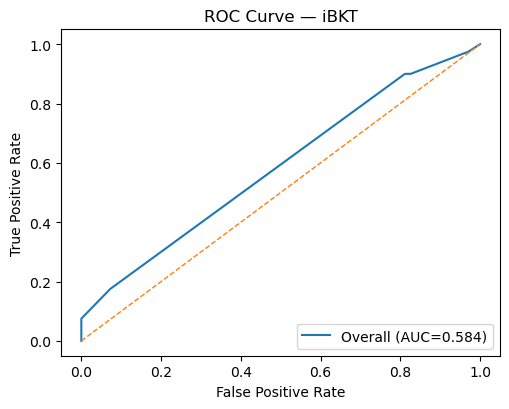

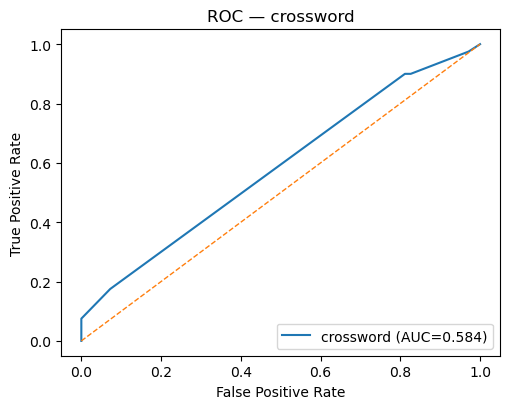

In [38]:
# ==========================================
# ROC curve (overall + by game type buckets)
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def collect_preds_labels(df, params: BKTParams=None):
    params = params or BKTParams()
    # ensure temporal order
    sort_cols = ["user_id"]
    if "timestamp" in df.columns: sort_cols.append("timestamp")
    if {"session_id","q_idx"}.issubset(df.columns): sort_cols += ["session_id","q_idx"]
    data = df.sort_values(sort_cols).reset_index(drop=True)

    preds, labels = [], []
    from collections import defaultdict
    pL = defaultdict(lambda: params.p_L0)

    for (u, s), g in data.groupby(["user_id","subtopic_id"], sort=False):
        p = pL[(u,s)]
        for _, row in g.iterrows():
            p_correct = p * (1 - params.p_S) + (1 - p) * params.p_G
            preds.append(float(np.clip(p_correct, 1e-9, 1-1e-9)))
            labels.append(int(row.is_correct))
            p = bkt_update_once(p, bool(row.is_correct), params)
        pL[(u,s)] = p
    return np.array(preds), np.array(labels)

# Overall ROC
preds_all, labels_all = collect_preds_labels(df)
fpr, tpr, _ = roc_curve(labels_all, preds_all)
auc_all = roc_auc_score(labels_all, preds_all)

plt.figure(figsize=(5.2, 4.2))
plt.plot(fpr, tpr, label=f"Overall (AUC={auc_all:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — iBKT")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ROC by game type (optional small multiples)
for gtype, gdf in df.groupby("game_type"):
    p, y = collect_preds_labels(gdf)
    if len(np.unique(y)) < 2:
        print(f"[{gtype}] AUC undefined (only one class).")
        continue
    fpr, tpr, _ = roc_curve(y, p)
    auc = roc_auc_score(y, p)
    plt.figure(figsize=(5.2, 4.2))
    plt.plot(fpr, tpr, label=f"{gtype} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {gtype}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


No pairs with ≥12 interactions; plotting first available pair instead.


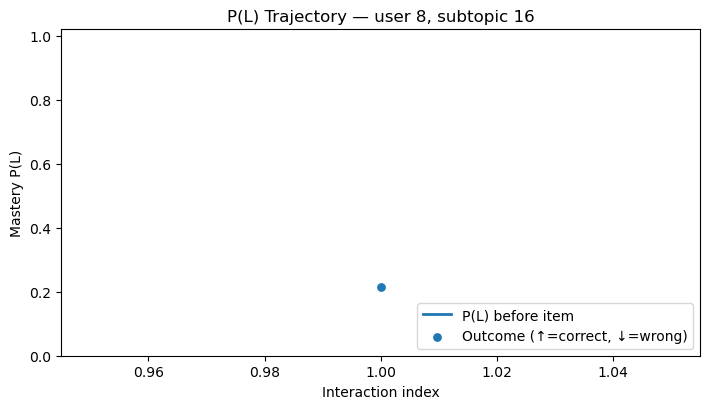

In [39]:
# =======================================================
# P(L) evolution for selected (user_id, subtopic_id) pairs
# =======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def pl_trajectory(df, user_id, subtopic_id, params: BKTParams=None):
    params = params or BKTParams()
    q = df[(df["user_id"]==user_id) & (df["subtopic_id"]==subtopic_id)].copy()
    if q.empty:
        print(f"No rows for user={user_id}, subtopic={subtopic_id}")
        return

    sort_cols = []
    if "timestamp" in q.columns: sort_cols.append("timestamp")
    if {"session_id","q_idx"}.issubset(q.columns): sort_cols += ["session_id","q_idx"]
    if sort_cols:
        q = q.sort_values(sort_cols)
    q = q.reset_index(drop=True)

    ps = []          # P(L) before each item
    p_corrects = []  # predicted P(correct)
    outcomes = []    # 0/1
    p = params.p_L0

    for _, row in q.iterrows():
        ps.append(p)
        p_correct = p * (1 - params.p_S) + (1 - p) * params.p_G
        p_corrects.append(float(np.clip(p_correct, 1e-9, 1-1e-9)))
        outcomes.append(int(row.is_correct))
        p = bkt_update_once(p, bool(row.is_correct), params)

    steps = np.arange(1, len(ps)+1)

    plt.figure(figsize=(7.2, 4.2))
    plt.plot(steps, ps, linewidth=2, label="P(L) before item")
    # overlay outcomes as scatter (1=correct on top, 0=wrong lower)
    y_marks = np.array(ps) + (np.array(outcomes)*0.03 - 0.015)  # small offset
    plt.scatter(steps, y_marks, marker="o", s=28, label="Outcome (↑=correct, ↓=wrong)")
    plt.ylim(0, 1.02)
    plt.xlabel("Interaction index")
    plt.ylabel("Mastery P(L)")
    plt.title(f"P(L) Trajectory — user {user_id}, subtopic {subtopic_id}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Helper: pick a couple of pairs with enough observations (>= 12)
pair_counts = (df.groupby(["user_id","subtopic_id"]).size()
                 .reset_index(name="n"))
candidates = pair_counts[pair_counts["n"] >= 12].head(3)

if candidates.empty:
    print("No pairs with ≥12 interactions; plotting first available pair instead.")
    candidates = pair_counts.head(1)

for _, row in candidates.iterrows():
    pl_trajectory(df, int(row.user_id), int(row.subtopic_id))


## Use actual data: user_id = 3, subtopic_id = 15

Below we filter the existing `df` (generated or real) for the specific user/subtopic you asked about, compute log-likelihood and AUC-ROC using the notebook's `eval_ibkt_ll_auc` helper, and plot the P(L) trajectory with `pl_trajectory`.

In [40]:
# Filter df for the requested user and subtopic
user_id = 3
subtopic_id = 15
df_subset = df[(df.user_id == user_id) & (df.subtopic_id == subtopic_id)].copy()

if df_subset.empty:
    print(f"No rows found for user_id={user_id}, subtopic_id={subtopic_id}. Check that those IDs exist in `df`.")
else:
    print(f"Found {len(df_subset)} rows for user_id={user_id}, subtopic_id={subtopic_id}.")
    # Compute LL/AUC using the existing helper
    metrics = eval_ibkt_ll_auc(df_subset.copy())
    print("\n=== Metrics for subset ===")
    print(f"n_obs: {metrics['n_obs']}")
    print(f"Log-Likelihood (total): {metrics['log_likelihood']:.6f}")
    print(f"Avg Log-Likelihood: {metrics['avg_log_likelihood']:.6f}")
    print(f"AUC-ROC: {metrics['auc_roc']}")

No rows found for user_id=3, subtopic_id=15. Check that those IDs exist in `df`.


In [41]:
# Show a sample of the subset and plot P(L) trajectory if there are enough rows
from IPython.display import display
if df_subset.empty:
    pass
else:
    display(df_subset.sort_values(["timestamp","session_id","q_idx"]).reset_index(drop=True).head(20))
    # Plot P(L) trajectory using the notebook's helper
    try:
        pl_trajectory(df, user_id, subtopic_id)
    except Exception as e:
        print("Error plotting P(L) trajectory:", e)

In [ ]:
# Metrics helper: AUC 95% CI (bootstrap) and log-loss baseline comparison
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss

try:
    y_true = labels_all
    y_pred = preds_all
except NameError:
    print("Required variables `labels_all` and `preds_all` are not defined yet. Run evaluation cells first.")
else:
    rng = np.random.default_rng(42)
    n = len(y_true)
    B = 2000  # bootstrap samples

    auc_samples = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        # Guard: AUC undefined if only one class present in resample
        if len({int(v) for v in y_true[idx]}) < 2:
            continue
        auc_samples.append(roc_auc_score(y_true[idx], y_pred[idx]))

    if len(auc_samples) == 0:
        print("AUC bootstrap failed: resamples lacked class variety. Consider more data.")
    else:
        lo, hi = np.percentile(auc_samples, [2.5, 97.5])
        print(f"AUC: {roc_auc_score(y_true, y_pred):.3f} (95% CI: {lo:.3f}–{hi:.3f}, B={len(auc_samples)})")

    # Compare avg log-loss to a naive prevalence baseline
    try:
        p_base = np.clip(np.mean(y_true), 1e-6, 1 - 1e-6)
        ll_model = -log_loss(y_true, y_pred, labels=[0,1])
        ll_base = -log_loss(y_true, np.full_like(y_pred, p_base), labels=[0,1])
        print(f"Avg log-likelihood (model): {ll_model:.4f}")
        print(f"Avg log-likelihood (baseline p={p_base:.3f}): {ll_base:.4f}")
        delta = ll_model - ll_base
        print(f"Improvement vs baseline: {delta:+.4f} (higher is better)")
    except Exception as e:
        print(f"Baseline comparison skipped: {e}")
